In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

In [3]:
data = json.load(open("validation_ours.json"))

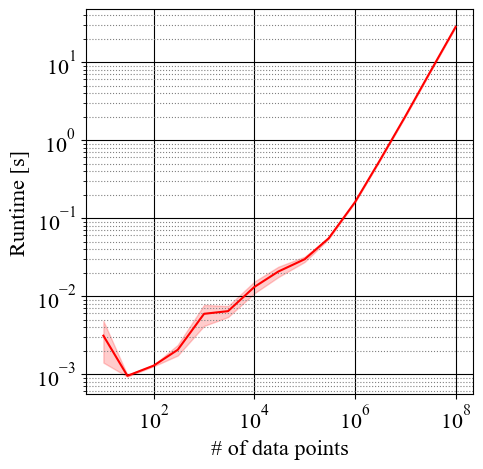

In [13]:
x, m, s = [], [], []
for N, result in data.items():
    x.append(int(N))
    m.append(np.mean(result["runtime"]))
    s.append(np.std(result["runtime"]) / np.sqrt(10))

x, m, s = map(np.asarray, [x, m, s])

_, ax = plt.subplots(figsize=(5, 5))
ax.plot(x, m, color="red")
ax.fill_between(x, m - s, m + s, alpha=0.2, color="red")
ax.set_xlabel("# of data points")
ax.set_ylabel("Runtime [s]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(which='minor', color='gray', linestyle=':')
ax.grid(which='major', color='black')